In [1]:
from IPython.display import IFrame, Image, display
import numpy as np
import math
import zarr
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import xarray as xr
import torch
import torch.nn as nn
import pandas as pd
from scipy.signal import savgol_filter
import gc
import imageio
from io import BytesIO
import geopandas as gpd
from rasterio import features
from affine import Affine
from shapely.geometry import Point
from functions import *

In [2]:
# area location
IFrame(
    "https://map.geo.admin.ch/#/map?lang=de&center=2644008.2,1133794.76&z=6.881&topic=ech&layers=ch.swisstopo.zeitreihen@year=1864,f;ch.bfs.gebaeude_wohnungs_register,f;ch.bav.haltestellen-oev,f;ch.swisstopo.swisstlm3d-wanderwege,f;ch.vbs.schiessanzeigen,f;ch.astra.wanderland-sperrungen_umleitungen,f&bgLayer=ch.swisstopo.swissimage",
    width=1000,
    height=600
)

In [2]:
# data loading and raster initialization
# ----- Config -----
zarr_path = "/data_2/scratch/sbiegel/processed/ndvi_dataset.zarr/ndvi"
mask_path = "/data_2/scratch/sbiegel/processed/forest_mask.npy"

z = zarr.open(zarr_path, mode="r")

# Raster info
height, width = 24542, 37728
left, bottom = 2474090.0, 1065110.0
px = 10.0
top = bottom + height * px

In [4]:
# area extraction

# ----- load polygon from SHP -----
gdf = gpd.read_file("storm_reference_burglind.shp")
gdf = gdf.to_crs(epsg=2056)   # Swiss LV95
gdf["geometry"] = gdf["geometry"].buffer(0)

polygon = gdf.geometry.unary_union

# ----- raster info -----
height, width = 24542, 37728
left, bottom = 2474090.0, 1065110.0
px = 10.0
top = bottom + height * px

# ----- polygon bounds -> pixel window -----
x_min, y_min, x_max, y_max = polygon.bounds

col_min = int(math.floor((x_min - left) / px))
col_max = int(math.floor((x_max - left) / px))
row_min = int(math.floor((top - y_max) / px))
row_max = int(math.floor((top - y_min) / px))

# clip to raster extent
col_min = max(0, min(width - 1, col_min))
col_max = max(0, min(width - 1, col_max))
row_min = max(0, min(height - 1, row_min))
row_max = max(0, min(height - 1, row_max))

win_cols = col_max - col_min + 1
win_rows = row_max - row_min + 1
print(f"Window cols {col_min}..{col_max} ({win_cols}), rows {row_min}..{row_max} ({win_rows})")

# ----- load mask -----
mask = np.load(mask_path)
assert mask.shape == (height, width), f"Mask shape {mask.shape} != raster {(height, width)}"

mask_flat = mask.ravel(order="C")
masked_positions = np.flatnonzero(mask_flat)
n_masked = masked_positions.size
print(f"Mask has {n_masked} True pixels.")

# build index map from full array -> masked array
idx_map = np.full(mask_flat.shape[0], -1, dtype=np.int64)
idx_map[masked_positions] = np.arange(n_masked, dtype=np.int64)

# ----- compute pixel centers in window -----
rows = np.arange(row_min, row_max + 1, dtype=np.int64)
cols = np.arange(col_min, col_max + 1, dtype=np.int64)
rr, cc = np.meshgrid(rows, cols, indexing="ij")

xx = left + (cc + 0.5) * px
yy = top - (rr + 0.5) * px

# ----- rasterize polygon to mask (fast) -----
transform = Affine(px, 0, left, 0, -px, top)
poly_mask = features.rasterize(
    [(polygon, 1)],
    out_shape=(height, width),
    transform=transform,
    fill=0,
    dtype="uint8"
)

# extract only window
inside_mask = poly_mask[row_min:row_max+1, col_min:col_max+1].astype(bool)

# flatten to keep same workflow
inside = inside_mask.ravel()

# ----- flat indices -----
full_flat_idx = (rr * width + cc).ravel()

# keep only pixels inside polygon
poly_flat_idx = full_flat_idx[inside]

masked_idx_in_window = idx_map[poly_flat_idx]
is_masked = masked_idx_in_window >= 0
n_masked_in_window = is_masked.sum()
print(f"Pixels in window: {full_flat_idx.size}, masked pixels in polygon: {n_masked_in_window}")

if n_masked_in_window == 0:
    raise RuntimeError("No masked pixels in polygon!")

sel = masked_idx_in_window[is_masked].tolist()



# ----- open Zarr -----
N, T = z.shape
assert N == n_masked, f"Zarr first-dim {N} != mask True count {n_masked}"

# ----- plotting extent -----
extent = (
    left + col_min * px,
    left + (col_max + 1) * px,
    top - (row_max + 1) * px,
    top - row_min * px,
)

# Limit to first timesteps
d_frames = min(1000, T)

/tmp/ipykernel_1179698/1127178932.py:8: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  polygon = gdf.geometry.unary_union


Window cols 14860..15467 (608), rows 7321..7625 (305)
Mask has 105715396 True pixels.
Pixels in window: 185440, masked pixels in polygon: 7518


In [9]:
print(sel[len(sel)//2])

20302016


/home/francesco/miniconda3/envs/ndvi/lib/python3.11/site-packages/zarr/codecs/vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)


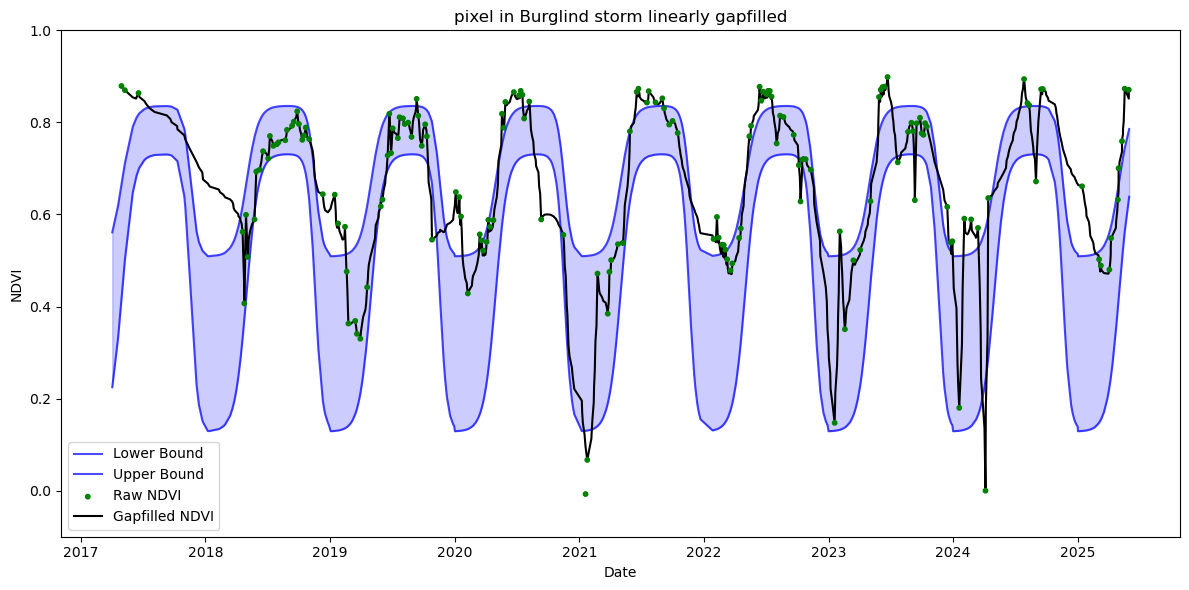

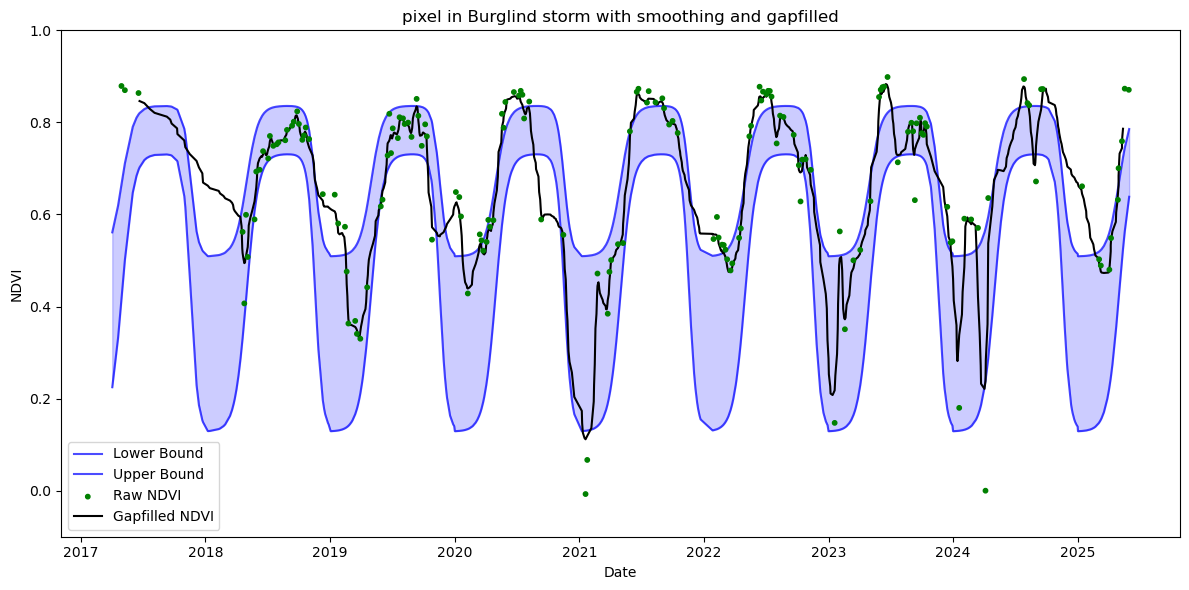

In [11]:
# fitting and smoothing
# ----- seasonal cycle fitting -----
ds = xr.open_zarr("/data_2/scratch/sbiegel/processed/sample_seasonal_cycle_parameter_preds_updated.zarr")
ndvi = ds["ndvi"]
dates = ds["dates"]
params_lower = torch.tensor(ds["params_lower"].values)
params_upper = torch.tensor(ds["params_upper"].values)

# convert dates to doy
dates_pd = pd.to_datetime(dates)
df = pd.DataFrame({"date": dates_pd})
df_sorted = df.sort_values(by="date")
dates_sorted = df_sorted["date"].values
dates_pd_sorted = pd.to_datetime(dates_sorted)
doy = dates_pd_sorted.dayofyear.values
doy = torch.tensor(doy, dtype=torch.float32)
T_SCALE = 1.0 / 365.0
t = doy.unsqueeze(0).repeat(params_lower.shape[0], 1) * T_SCALE


lower = double_logistic_function(t[[0]], params_lower[[91]]).squeeze().cpu().numpy()
upper = double_logistic_function(t[[0]], params_upper[[91]]).squeeze().cpu().numpy()

median_iqr = upper - (upper - lower) / 2

param_iqr = 1.5
bottom_iqr = 0.9
upper_iqr = 0.1
window_length = 14
polyorder = 2


random_pixels = int(np.median(sel))  # pick one pixel index to check

ndvi_series = z[random_pixels, :]

# proper sorting

df = pd.DataFrame({
    'date': dates_pd,
    'ndvi': ndvi_series
    })

df_sorted = df.sort_values(by='date')

ndvi_sorted = df_sorted['ndvi'].values

ndvi_gapfilled, outlier_arr = gapfill_ndvi(ndvi_sorted, lower, upper)

smoothed_data = savgol_filter(ndvi_gapfilled, window_length=window_length, polyorder=polyorder) 


plot_results(
        title= "pixel in Burglind storm linearly gapfilled",
        pixel_idx=random_pixels,
        ndvi_series=ndvi_sorted / 10000.0,
        ndvi_gapfilled=ndvi_gapfilled,
        outlier_arr=outlier_arr,
        lower=lower,
        upper=upper,
        dates=dates_sorted
    )

plot_results(
        title= "pixel in Burglind storm with smoothing and gapfilled",
        pixel_idx=random_pixels,
        ndvi_series=ndvi_sorted / 10000.0, 
        ndvi_gapfilled=smoothed_data,
        outlier_arr=outlier_arr,
        lower=lower,
        upper=upper,
        dates=dates_sorted
    )


In [12]:
# continous gapfilling and smoothing
ndvi_filled, outlier_arr, forecast_only, smoothed = gapfill_ndvi(ndvi_sorted, lower, upper,forecasting=True)
ndvi_gapfilled, outlier_mask =gapfill_ndvi(ndvi_sorted, lower, upper,forecasting=False)

In [7]:
print(ndvi_series)

[32767     0 32767 ... 32767  9363 32767]


KeyboardInterrupt: 

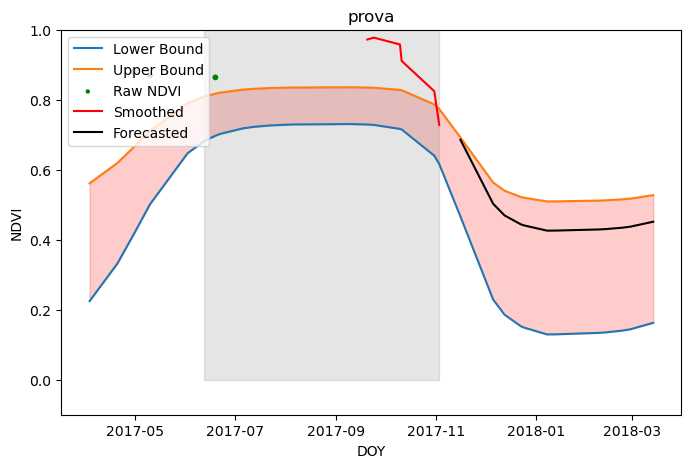

In [ ]:
frames = []

n = len(smoothed)

ndvi_timeseries = ndvi_sorted / 10000

# assign cloud mask as nan
ndvi_timeseries = np.where((ndvi_timeseries > 1) | (ndvi_timeseries < 0), np.nan, ndvi_timeseries)

for t in range(14, n):
    fig, ax = plt.subplots(figsize=(8, 5))

    colors = np.where(outlier_arr[:t], "red", "green")


    ax.plot(dates_sorted[:t], lower[:t], label="Lower Bound")
    ax.plot(dates_sorted[:t], upper[:t], label="Upper Bound")
    ax.fill_between(dates_sorted[:t], lower[:t], upper[:t], alpha=0.2, color="red")
    ax.scatter(dates_sorted[:t], ndvi_timeseries[:t], s=10, color=colors[:t], label="Raw NDVI", zorder=3)

    # Smoothed data: t=14 to t-14
    if t > 14:
        ax.plot(dates_sorted[14:t-13], smoothed[14:t-13], color="red", label="Smoothed")
        ax.fill_between(dates_sorted[t-28:t-13], 0, 1, alpha=0.2, color="gray")


    # Forecasted data: t-13 to t
    ax.plot(dates_sorted[max(0,t-13):t], forecast_only[max(0,t-13):t], color="black", label="Forecasted")

    ax.set_title("prova")
    ax.set_ylim(-0.1, 1)
    ax.set_xlabel("DOY")
    ax.set_ylabel("NDVI")
    ax.legend(loc="upper left")
    plt.tight_layout()

    # Save frame to memory
    buf = BytesIO()
    plt.savefig(buf, format="png", dpi=100)
    buf.seek(0)
    frames.append(imageio.v2.imread(buf))
    plt.close()

gif_filename = "continous_integration_Burglind.gif"
imageio.mimsave(gif_filename, frames, duration=0.05)

# Display in notebook
display(Image(filename=gif_filename))

In [9]:
# area non affected by fire
